Installs

In [6]:
# Install Prophet
!pip install prophet -q

Libraries

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.seasonal import seasonal_decompose
from prophet import Prophet
import warnings
warnings.filterwarnings("ignore")

Load dataset


In [8]:
# --- Load & Parse Data ---
df = pd.read_csv('Walmart.csv')
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)

Seasonal & Weekly looks

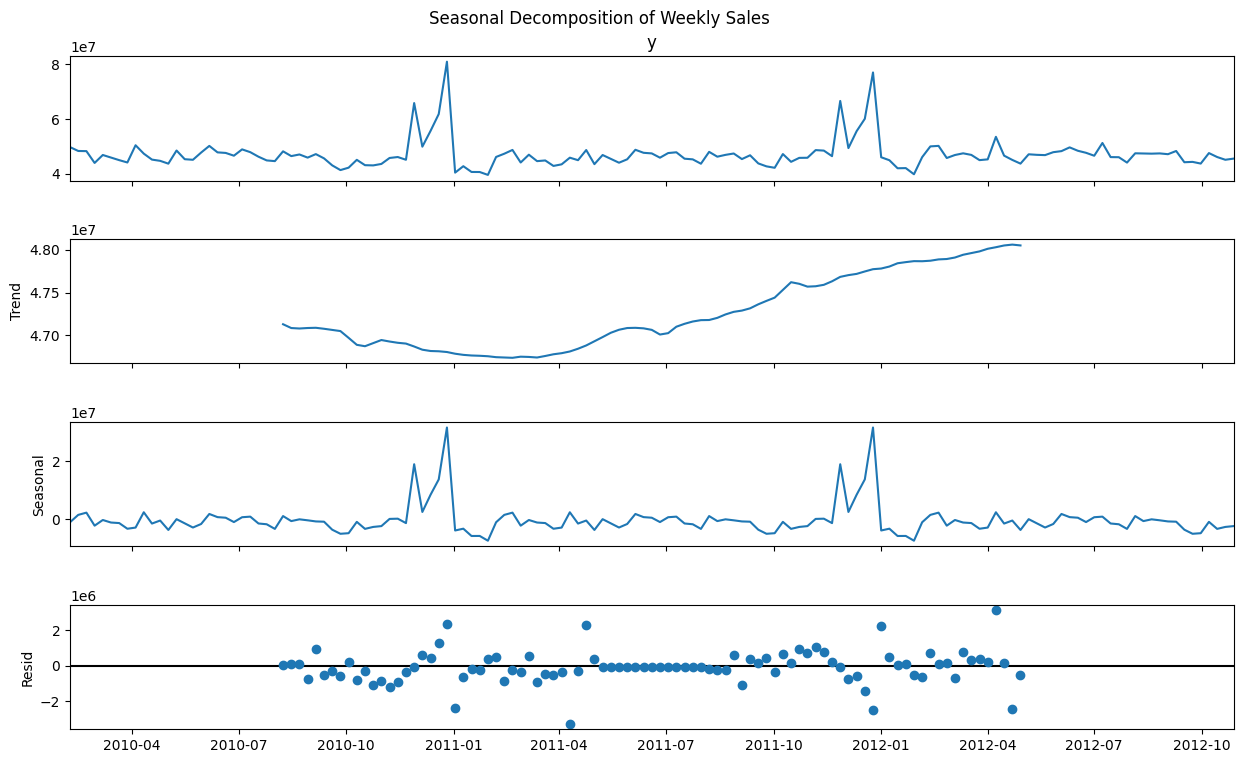

In [9]:

# --- Weekly Aggregation (Sunday-based) ---
weekly_sales = df.resample('W-SUN', on='Date')['Weekly_Sales'].sum().reset_index()
weekly_sales.columns = ['ds', 'y']

# --- Seasonal Decomposition ---
decomp_data = weekly_sales.set_index('ds')
decomposition = seasonal_decompose(decomp_data['y'], model='additive', period=52)
fig = decomposition.plot()
fig.set_size_inches(14, 8)
plt.suptitle("Seasonal Decomposition of Weekly Sales")
plt.show()

Training & Prophet Model

In [10]:
# --- Train-Test Split ---
train = weekly_sales[weekly_sales['ds'] < '2012-01-01']
test = weekly_sales[weekly_sales['ds'] >= '2012-01-01']

# --- Prophet Model ---
model = Prophet()
model.fit(train)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpd1e4dnvw/wupk5sim.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpd1e4dnvw/dzfm1d4r.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=2577', 'data', 'file=/tmp/tmpd1e4dnvw/wupk5sim.json', 'init=/tmp/tmpd1e4dnvw/dzfm1d4r.json', 'output', 'file=/tmp/tmpd1e4dnvw/prophet_modelrhdv6omx/prophet_model-20250803073254.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
07:32:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:32:55 - cmdstanpy - INFO - Chain

Forecasting

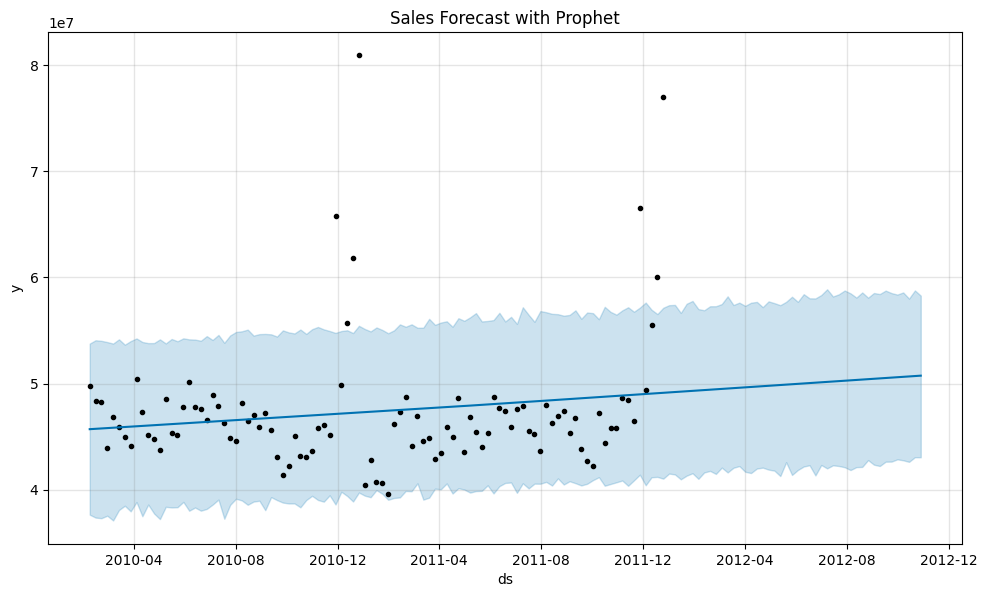

In [11]:
# --- Forecasting ---
future = model.make_future_dataframe(periods=len(test), freq='W-SUN')
forecast = model.predict(future)

# --- Plot Forecast ---
fig2 = model.plot(forecast)
plt.title("Sales Forecast with Prophet")
plt.show()

Evaluation

In [12]:
# --- Evaluation ---
# Use merge_asof to align nearest dates (more robust)
test_sorted = test.sort_values('ds')
forecast_sorted = forecast[['ds', 'yhat']].sort_values('ds')
merged = pd.merge_asof(test_sorted, forecast_sorted, on='ds', direction='nearest')

Metrics

In [14]:
# Metrics
forecast_test = merged['yhat'].values
actual_test = merged['y'].values
rmse = np.sqrt(mean_squared_error(actual_test, forecast_test))
mae = mean_absolute_error(actual_test, forecast_test)

print(f"\n Prophet Model RMSE: {rmse:.2f}")
print(f" Prophet Model MAE : {mae:.2f}")


 Prophet Model RMSE: 4206117.09
 Prophet Model MAE : 3737351.39


Visualization

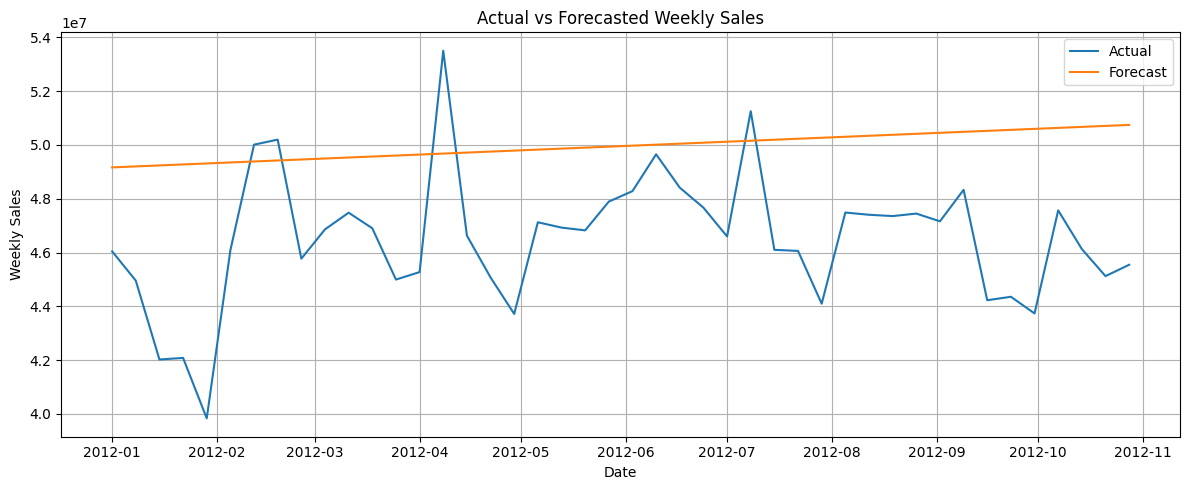

In [15]:
# --- Plot Actual vs Forecast ---
plt.figure(figsize=(12, 5))
plt.plot(merged['ds'], actual_test, label='Actual')
plt.plot(merged['ds'], forecast_test, label='Forecast')
plt.title("Actual vs Forecasted Weekly Sales")
plt.xlabel("Date")
plt.ylabel("Weekly Sales")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
